<a href="https://colab.research.google.com/github/SlickMik/ensf692Project/blob/main/ENSF_692_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%autosave 2

Autosaving every 2 seconds


# ESNF 692 Project
### Group # : 4
##### Authors : Danish Shahid () | Muhammad Ibrahim Khan ()
---

This notebook describes the correlation of asset classes - Oil, Gold, and S&P500 for a user selected time range

---

Importing Libraries

In [2]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib as mp
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.dates as mdates

# Dataset Selection

Downloading Kaggle Datasets

In [3]:
# Download latest dataset versions
gold_dataset_path = kagglehub.dataset_download("faisaljanjua0555/daily-gold-price-historical-dataset")

oil_dataset_path = kagglehub.dataset_download("guillemservera/fuels-futures-data")

sp_dataset_path = kagglehub.dataset_download("youcanttouchthis/s-p-500-dataset")

100%|██████████| 87.0k/87.0k [00:00<00:00, 10.2MB/s]

Extracting files...


100%|██████████| 1.21M/1.21M [00:00<00:00, 67.6MB/s]

Extracting files...


100%|██████████| 179k/179k [00:00<00:00, 67.8MB/s]

Extracting files...


# Dataset Creation

* Reading Dataset to Pandas<br/>
* Dropping unnecessary columns<br/>
* Setting index to Date<br/>
* Parsing Date

In [4]:
# read csv files into pandas
gold_dataset = pd.read_csv(gold_dataset_path + f'/gold.csv', index_col='Date', parse_dates=True)

oil_dataset = pd.read_csv(oil_dataset_path + f'/all_fuels_data.csv', index_col='date', parse_dates=True)

sp_dataset = pd.read_csv(sp_dataset_path + f'/spy.csv', index_col='Date', parse_dates=True)

Gold Dataset
* Dropping Columns
* Renaming Columns

Describing Gold Dataset

In [5]:
gold_dataset = gold_dataset.drop(columns='Currency').rename(columns = {c : f'Gold_{c}' for c in gold_dataset.columns})
gold_dataset.head(3)

,Gold_Open,Gold_High,Gold_Low,Gold_Close,Gold_Volume
Date,,,,,
2000-01-04,289.5,289.5,280.0,283.7,21621
2000-01-05,283.7,285.0,281.0,282.1,25448
2000-01-06,281.6,282.8,280.2,282.4,19055


Oil Dataset
* Dropping Columns
* Reorganizing Columns
* Renaming Columns
* Cleaning Columns

Describing Oil Dataset

In [6]:
oil_dataset = oil_dataset[oil_dataset['commodity'].str.lower().str.fullmatch('crude oil')]
oil_dataset = oil_dataset.drop(columns=['ticker', 'commodity'])
oil_dataset.rename_axis(index={'date':'Date'}, inplace=True)
oil_dataset.columns = oil_dataset.columns.str.capitalize()

oil_dataset = (
    oil_dataset[['Open', 'High', 'Low', 'Close', 'Volume']]
    .rename(columns={c : f'Oil_{c.title()}' for c in oil_dataset.columns})
)
oil_dataset.head(3)

,Oil_Open,Oil_High,Oil_Low,Oil_Close,Oil_Volume
Date,,,,,
2000-08-23,31.950001,32.799999,31.950001,32.049999,79385
2000-08-24,31.900000,32.240002,31.400000,31.629999,72978
2000-08-25,31.700001,32.099998,31.320000,32.049999,44601


S&P 500 Dataset
* Dropping Columns
* Renaming Columns

Describing S&P 500 Dataset

In [7]:
sp_dataset = sp_dataset.drop(columns='Adj Close').rename(columns = {c : f'S&P500_{c}' for c in sp_dataset.columns})
sp_dataset.head(3)

,S&P500_Open,S&P500_High,S&P500_Low,S&P500_Close,S&P500_Volume
Date,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,201300


Join Datasets

In [8]:
close_cols = ['S&P500_Close', 'Gold_Close', 'Oil_Close']
assets_df = sp_dataset[[close_cols[0]]].join(gold_dataset[[close_cols[1]]], how='outer').join(oil_dataset[[close_cols[2]]], how='outer')
assets_df.head(3)

,S&P500_Close,Gold_Close,Oil_Close
Date,,,
1993-01-29,43.93750,NaN,NaN
1993-02-01,44.25000,NaN,NaN
1993-02-02,44.34375,NaN,NaN


Drop Duplicated Columns If Any

In [9]:
if assets_df.columns.duplicated().any():
  assets_df = assets_df.T.drop_duplicates().T

Set Hierarchical Index on Rows

In [10]:
assets_df = assets_df.set_index(
    pd.MultiIndex.from_arrays(
        [assets_df.index.year,assets_df.index.month, assets_df.index.day], names=['Year', 'Month', 'Day']
        )
    )
assets_df.head(3)

S&P500_Close  Gold_Close  Oil_Close
Year Month Day                                     
1993 1     29       43.93750         NaN        NaN
     2     1        44.25000         NaN        NaN
           2        44.34375         NaN        NaN

In [25]:
assets_df.describe()

,S&P500_Close,Gold_Close,Oil_Close
count,7029.000000,5703.000000,5984.000000
mean,143.519237,1040.298282,64.477543
std,71.069322,518.524020,25.297096
min,43.406250,256.600000,-37.630001
25%,99.730003,460.500000,45.317501
50%,127.080002,1188.700000,63.075001
75%,181.119995,1383.050000,83.279997
max,372.239990,2069.400000,145.289993


---

# User Entry

In [89]:
print("Enter a start and end date between the range of 2000-08-23 & 2020-12-24 or enter 'n' to exit program")
min_date = pd.to_datetime('2000-08-23')
max_date = pd.to_datetime('2020-12-24')
status = True;

while status:
    try:
        start_date = pd.to_datetime(input('Enter the start date (e.g YYYY-MM-DD): '))
        end_date = pd.to_datetime(input('Enter the end date (e.g YYYY-MM-DD): '))
        rolling_period = int(input("Enter rolling period (e.g 20): "))
        if not (min_date <= start_date <= max_date):
            raise ValueError(f"Start date must be between {min_date.date()} and {max_date.date()}")
        if not (min_date <= end_date <= max_date):
            raise ValueError(f"End date must be between {min_date.date()} and {max_date.date()}")
        if start_date > end_date:
            raise ValueError("Start date must be before or equal to end date.")
        if rolling_period > 200:
            raise ValueError("Rolling period must be lower than 200")
        break
    except Exception as e:
        print(f"Invalid input: {e}")


Enter a start and end date between the range of 2000-08-23 & 2020-12-24 or enter 'n' to exit program
Enter the start date (e.g YYYY-MM-DD): 2001-01-01
Enter the end date (e.g YYYY-MM-DD): 2019-12-31
Enter rolling period (e.g 20): 20


Slicing Joined Asset Data Frame by Index

In [90]:
range_asset_df = assets_df.loc[(start_date.year, start_date.month, start_date.day):(end_date.year, end_date.month, end_date.day)]
range_asset_df.head(3)

S&P500_Close  Gold_Close  Oil_Close
Year Month Day                                     
2001 1     2      128.812500       270.0  27.200001
           3      135.000000       269.3  27.950001
           4      133.546875       268.4  28.200001

---

# Analysis & Calculations

* Rolling Window SMA on price
* Rolling Window Correlation - pct change()
* Beta - returns - pct change()
* Seasonality heatmap - average returns
* Alpha? - returns

### Simple Moving Average (Normalized)

In [91]:
sma_cols = {f'{x}' : f"""{x.replace('_Close', '')}_{rolling_period}-day_SMA""" for x in close_cols}
sma_df = range_asset_df[[*sma_cols.keys()]].rolling(window=rolling_period).mean().rename(columns = sma_cols).bfill()
sma_df /= sma_df.iloc[0]
sma_df.head(3)

S&P500_20-day_SMA  Gold_20-day_SMA  Oil_20-day_SMA
Year Month Day                                                    
2001 1     2                  1.0              1.0             1.0
           3                  1.0              1.0             1.0
           4                  1.0              1.0             1.0

### Price Change

In [92]:
perc_cols = {f'{x}' : f"""{x.replace('_Close', '')}_%Return""" for x in close_cols}
cum_cols = {f'{x}' : f"""{x.replace('_%Return', '')}_%CumReturn""" for x in perc_cols.values()}
range_asset_df = pd.concat([range_asset_df[[*perc_cols.keys()]],
                            range_asset_df[[*perc_cols.keys()]]
                            .pct_change(fill_method=None).multiply(100)
                            .rename(columns=perc_cols)
                            ], axis=1)
range_asset_df = pd.concat([range_asset_df,
                            range_asset_df[[*perc_cols.values()]]
                            .cumsum()
                            .rename(columns=cum_cols)
                            ], axis=1)
range_asset_df.head(3)

S&P500_Close  Gold_Close  Oil_Close  S&P500_%Return  \
Year Month Day                                                        
2001 1     2      128.812500       270.0  27.200001             NaN   
           3      135.000000       269.3  27.950001        4.803493   
           4      133.546875       268.4  28.200001       -1.076389   

                Gold_%Return  Oil_%Return  S&P500_%CumReturn  Gold_%CumReturn  \
Year Month Day                                                                  
2001 1     2             NaN          NaN                NaN              NaN   
           3       -0.259259     2.757353           4.803493        -0.259259   
           4       -0.334200     0.894454           3.727105        -0.593459   

                Oil_%CumReturn  
Year Month Day                  
2001 1     2               NaN  
           3          2.757353  
           4          3.651807

### Market Daily Direction Stats

In [128]:
def overall_trend(row):
  row_t_count = row.count()
  if row.isna().any():
    return ''
  elif (row > 0).sum() == row_t_count:
    return 'Upward'
  elif (row < 0).sum() == row_t_count:
    return 'Downward'
  else:
    return 'Mixed'

In [129]:
overall_trend_df = range_asset_df[[*perc_cols.values()]].reset_index()
overall_trend_df['OverAll_Trend'] = overall_trend_df[[*perc_cols.values()]].apply(overall_trend, axis=1)
overall_trend_df = overall_trend_df[~overall_trend_df['OverAll_Trend'].str.fullmatch('')]
overall_pivot_df = pd.pivot_table(overall_trend_df[['Month', 'OverAll_Trend', 'S&P500_%Return']], index='Month', columns='OverAll_Trend', aggfunc='count')
overall_pivot_df.columns = [a[1] for a in overall_pivot_df.columns.to_flat_index()]

### Monthly Returns Correlation

In [98]:
corr_cols = {f'{x}' : f"""{x.replace('_%Return', '')}_Corr""" for x in perc_cols.values()}
corr_df = range_asset_df[[*corr_cols.keys()]].groupby(level=[1]).corr().unstack()
corr_df.columns = [f"""{"_".join(a).replace('_%Return', '')}_Corr""" for a in corr_df.columns.to_flat_index()]
corr_df = corr_df[['S&P500_Gold_Corr', 'S&P500_Oil_Corr', 'Gold_Oil_Corr']]
corr_df.head(3)

,S&P500_Gold_Corr,S&P500_Oil_Corr,Gold_Oil_Corr
Month,,,
1,-0.040666,0.321704,0.183386
2,-0.047819,0.134820,0.033812
3,-0.029338,0.211489,0.312693


### Average Monthly Returns

In [99]:
monthlyReturns = range_asset_df[[*perc_cols.values()]].groupby(['Year', 'Month']).sum().groupby('Month').mean()
monthlyReturns.head(3)

,S&P500_%Return,Gold_%Return,Oil_%Return
Month,,,
1,0.509651,3.215443,1.586871
2,0.192106,1.267561,3.938017
3,0.895267,-0.321560,3.526561


### Beta

In [100]:
beta_df = monthlyReturns.cov().iloc[0]/monthlyReturns.var().iloc[0]
beta_df

,S&P500_%Return
S&P500_%Return,1.000000
Gold_%Return,-0.100360
Oil_%Return,-0.140568


### Alpha

In [101]:
alpha_df = monthlyReturns.mean() - beta_df * monthlyReturns['S&P500_%Return'].mean()
alpha_df

,0
S&P500_%Return,0.000000
Gold_%Return,0.904631
Oil_%Return,1.157264


---

# Export & Matplotlib

SMA Plot

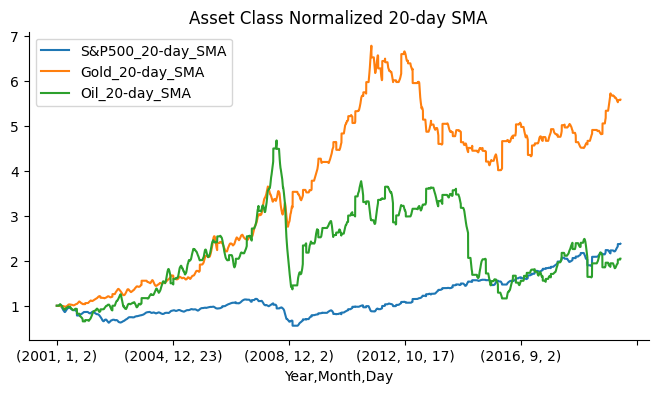

In [102]:
sma_df.plot(kind='line', figsize=(8, 4), title=f'Asset Class Normalized {rolling_period}-day SMA')
plt.gca().spines[['top', 'right']].set_visible(False)

daily returns 2008

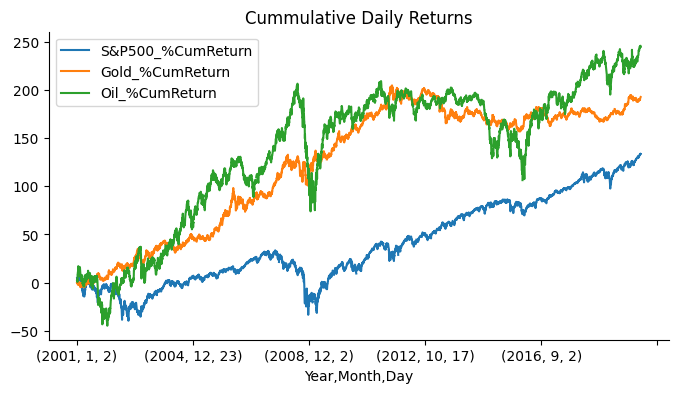

In [103]:
range_asset_df[[*cum_cols.values()]].plot(kind='line', figsize=(8, 4), title=f'Cummulative Daily Returns')
plt.gca().spines[['top', 'right']].set_visible(False)

Corr_Plot - bar char level from 0

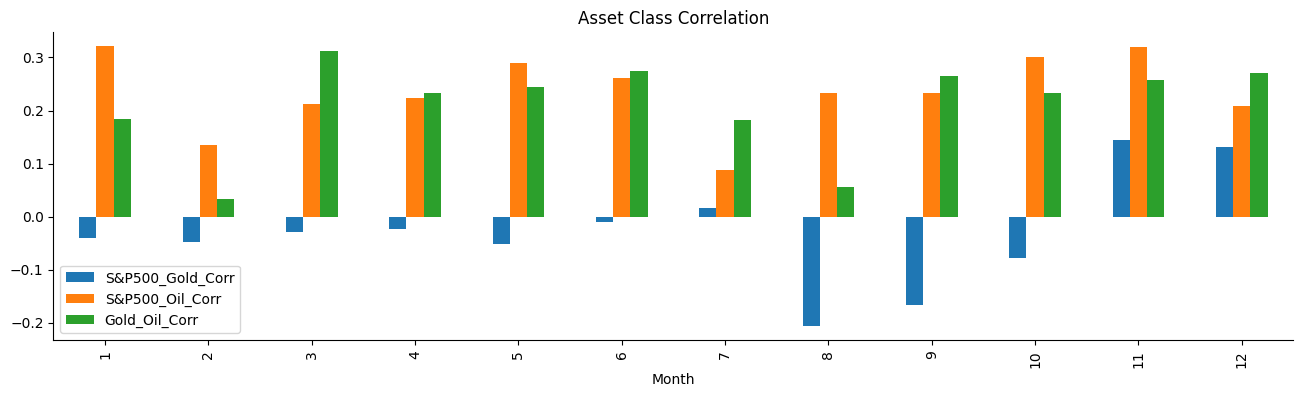

In [104]:
corr_df.plot(kind='bar', figsize=(16, 4), title=f'Asset Class Correlation')
plt.gca().spines[['top', 'right']].set_visible(False)

Market Daily Overall Trend

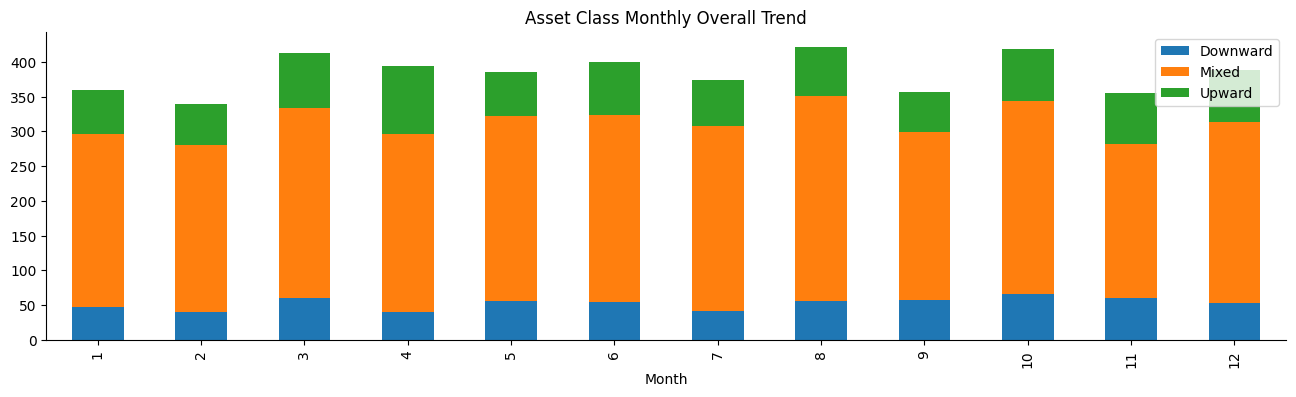

In [131]:
overall_pivot_df.plot(kind='bar', figsize=(16, 4), title=f'Asset Class Monthly Overall Trend', stacked=True)
plt.gca().spines[['top', 'right']].set_visible(False)

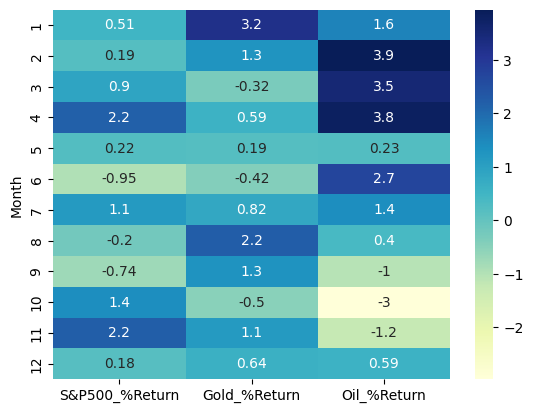

In [106]:
sb.heatmap(monthlyReturns, annot=True, cmap="YlGnBu")
plt.show()

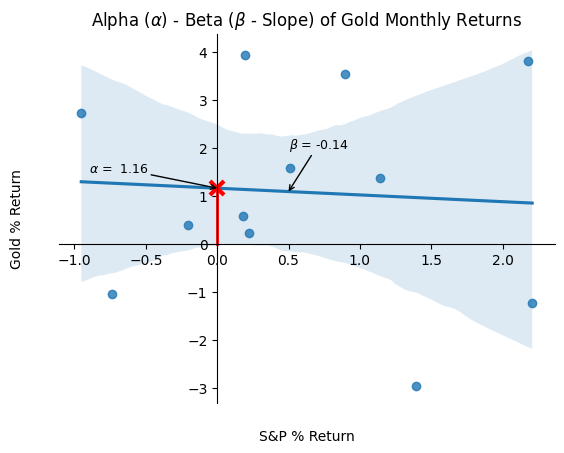

In [108]:
ret_col = 'Oil_%Return'
alpha = alpha_df[ret_col]
beta = beta_df[ret_col]
ax = sb.regplot(x="S&P500_%Return", y=ret_col, data=monthlyReturns)
ax.plot([0, 0], [0, alpha], color='red', linewidth=2)
ax.plot(0, alpha, marker='x', color='red', markersize=10, markeredgewidth=3)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
sb.despine()
ax.set_xlabel('S&P % Return')
ax.set_ylabel('Gold % Return')
ax.xaxis.set_label_coords(0.5, -0.07)
ax.yaxis.set_label_coords(-0.07, 0.5)
ax.annotate(
    f'$\\alpha$ = {alpha: .2f}',
    xy=(0, alpha),
    xytext=(-0.9, 1.5),
    textcoords='data',
    color='black',
    fontsize=9,
    arrowprops=dict(
        arrowstyle='->',
        color='black',
        lw=1,
        shrinkA=0, shrinkB=0
    )
);

ax.annotate(
    f'$\\beta$ = {beta: .2f}',
    xy=(0.5, alpha + (beta * 0.5)),
    xytext=(0.5, 2),
    textcoords='data',
    color='black',
    fontsize=9,
    arrowprops=dict(
        arrowstyle='->',
        color='black',
        lw=1,
        shrinkA=0, shrinkB=0
    )
);
ax.set_title("Alpha ($\\alpha$) - Beta ($\\beta$ - Slope) of Gold Monthly Returns");